<a href="https://colab.research.google.com/github/bwbayu/Deep-Learning-Projects/blob/main/Image-Classification/Classification%20of%20online%20gambling%20advertisements/Code_penelitian_IklanJudiOnline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import library

In [ ]:
import numpy as np
import os
import zipfile
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Setting randomseeds untuk menjaga random values memiliki nilai yang sama ketika dijalankan berulang kali

In [ ]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
reset_random_seeds()

In [ ]:
# # unzip files
# local_zip = '/content/drive/MyDrive/Semester 5/Deep Learning/Dataset/penelitian_iklan/dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/MyDrive/Semester 5/Deep Learning/Dataset/penelitian_iklan')
# zip_ref.close()

In [ ]:
base_dir = '/content/drive/MyDrive/Semester 5/Deep Learning/Dataset/penelitian_iklan/dataset/'
os.listdir(base_dir)

['judol', 'non-judol']

## Explore dataset

In [ ]:
import pathlib
data_dir = pathlib.Path(base_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1221


In [ ]:
list_dir = [os.path.basename(x) for x in data_dir.iterdir() if x.is_dir()]
print("Jumlah class: {} ".format(len(list_dir)))
print("Jumlah instance per class")
for x in list_dir:
 print("{} = {} ".format(x,len(list(data_dir.glob('{}/*.jpg'.format(x))))))

Jumlah class: 2 
Jumlah instance per class
judol = 625 
non-judol = 596 


## Setting batch size (pembagian dataset, 32 artinya dari 1000 data akan dibagi menjadi 32 batch), height dan width untuk image agar ukuran setiap gambar sama

In [ ]:
SBATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 200

## Proses preprocessing data image menggunakan ImageDataGenerator untuk memberikan variasi terhadap data training dan memberikan rasio pembagian untuk data training : data validation : data testing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.3,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
        base_dir,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training')

valid_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.25
    )

valid_generator = valid_datagen.flow_from_directory(
        base_dir,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.05)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Buat subset baru untuk uji
)

Found 867 images belonging to 2 classes.
Found 309 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


## Explore gambar hasil preprocessing

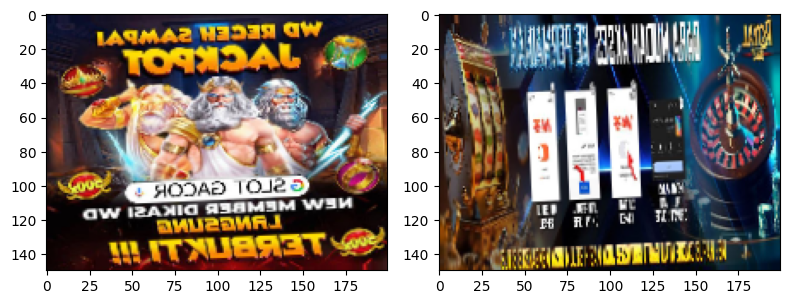

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = train_generator.next()

# Function to plot two original images
def plot_original_images(images, labels):
    num_images = min(2, len(images))
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[0])

    plt.subplot(1, 2, 2)
    plt.imshow(images[1])

    plt.tight_layout()
    plt.show()

# Plot two original images
plot_original_images(images, labels)


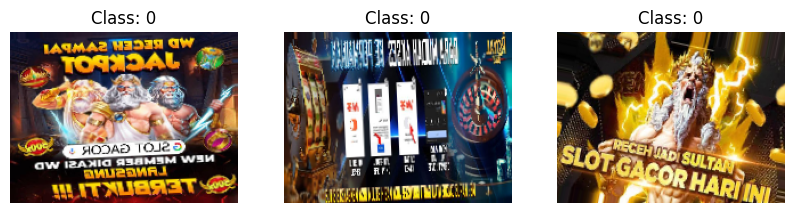

In [ ]:
plt.figure(figsize=(10, 10))
# for j in range(2):
x_batch, y_batch = next(train_generator)
for i in range(min(len(x_batch), 3)):  # Displaying up to 9 images
    plt.subplot(3, 3, i + 1)
    image = x_batch[i]
    plt.imshow(image)
    plt.title(f'Class: {int(y_batch[i])}')
    plt.axis("off")

plt.show()

## membuat fungsi untuk menampilkan akurasi dan loss selama proses training model

In [ ]:
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

## membuat fungsi callback untuk memberhentikan proses trainig ketika akurasi diatas 95% dan loss dibawah 1%

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95 and logs.get('loss') < 0.1 and logs.get('val_loss') < 0.1 ):
      # print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True

## Inisialisasi model transfer learning

In [ ]:
resnet50 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
# memotong layer terakhir untuk disesuaikan dengan penelitian ini
for layer in resnet50.layers:
    layer.trainable = False


## Pengembangan arsitektur ResNet dengan menambahkan beberapa layer pada fully connected layer

In [ ]:
model_resnet = tf.keras.models.Sequential()
model_resnet.add(resnet50)
model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dropout(0.2))
model_resnet.add(tf.keras.layers.Dense(64, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.2))
model_resnet.add(tf.keras.layers.Dense(32, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.2))
model_resnet.add(tf.keras.layers.Dense(16, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.2))
model_resnet.add(tf.keras.layers.Dense(1, activation='sigmoid'))

## Konfigurasi Model Resnet

In [ ]:
model_resnet.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## Proses training model

In [ ]:
history_resnet = model_resnet.fit(train_generator,
      epochs=30,
      validation_data = valid_generator,
      callbacks = myCallback()
      )

Epoch 1/30
28/28 [==============================] - 396s 14s/step - loss: 1.3755 - accuracy: 0.6078 - val_loss: 0.5998 - val_accuracy: 0.6052
Epoch 2/30
28/28 [==============================] - 14s 502ms/step - loss: 0.6572 - accuracy: 0.6782 - val_loss: 0.2728 - val_accuracy: 0.9288
Epoch 3/30
28/28 [==============================] - 14s 498ms/step - loss: 0.4984 - accuracy: 0.7670 - val_loss: 0.2079 - val_accuracy: 0.9417
Epoch 4/30
28/28 [==============================] - 14s 502ms/step - loss: 0.3998 - accuracy: 0.8293 - val_loss: 0.1645 - val_accuracy: 0.9482
Epoch 5/30
28/28 [==============================] - 14s 493ms/step - loss: 0.3781 - accuracy: 0.8454 - val_loss: 0.1388 - val_accuracy: 0.9547
Epoch 6/30
28/28 [==============================] - 14s 503ms/step - loss: 0.2969 - accuracy: 0.8777 - val_loss: 0.1285 - val_accuracy: 0.9547
Epoch 7/30
28/28 [==============================] - 14s 506ms/step - loss: 0.2831 - accuracy: 0.8870 - val_loss: 0.1168 - val_accuracy: 0.9547


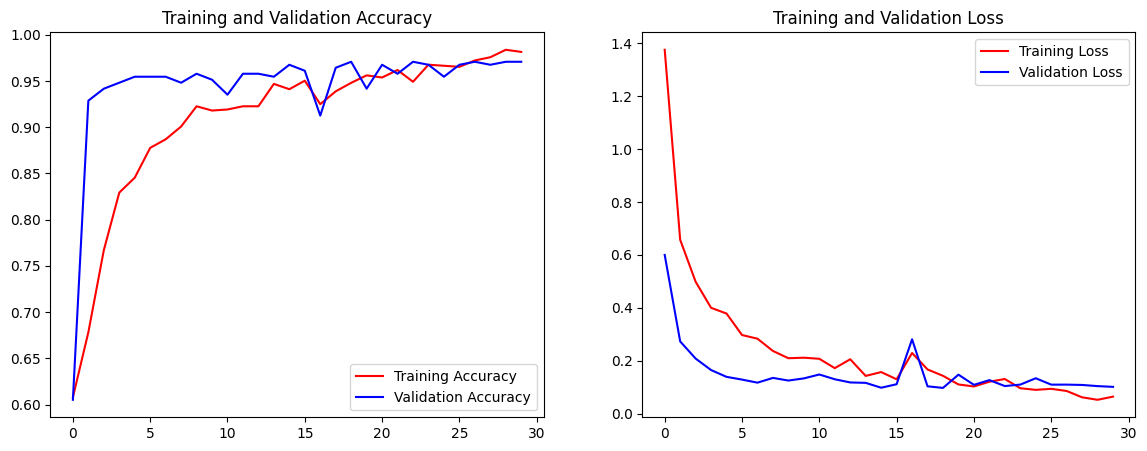

In [ ]:
eval_plot(history_resnet)

## Save Model

In [ ]:
# model_resnet.save('/content/drive/MyDrive/Semester 5/Deep Learning/model_6_12_23_21_40.h5')
model_resnet.save('/content/drive/MyDrive/Semester 5/Deep Learning/model_19_12_23.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Model

In [ ]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model in Google Drive
model_path = '/content/drive/MyDrive/Semester 5/Deep Learning/model_19_12_23.h5'

# Load the model
loaded_model = load_model(model_path)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 71680)             0         
                                                                 
 dropout (Dropout)           (None, 71680)             0         
                                                                 
 dense (Dense)               (None, 64)                4587584   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

## Menggunakan data testing pada model

In [ ]:
prediksi = loaded_model.evaluate(
    test_generator,
    batch_size=BATCH_SIZE
)

2/2 [==============================] - 17s 10s/step - loss: 0.0742 - accuracy: 0.9836


## Menghitung AUC-ROC Model untuk menetapkan Threshold model klasifikasi

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

true_labels = []
predicted_scores = []

for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)

    # Make predictions for the batch
    predictions = loaded_model.predict(x_batch)
    # Append true labels and predicted scores
    true_labels.extend(y_batch)
    predicted_scores.extend(predictions)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_scores = np.array(predicted_scores)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 8))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


1/1 [==============================] - 1s 820ms/step


In [ ]:
# Compute precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)
average_precision = average_precision_score(true_labels, predicted_scores)

# Plot precision-recall curve
# plt.figure(figsize=(8, 8))
# plt.step(recall, precision, color='b', where='post', label=f'AP = {average_precision:.2f}')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='upper right')
# plt.show()

## Menghitung confusion matrix terhadap model berdasarkan nilai threshold yang ditentukan

In [ ]:
# Choose a threshold based on your specific requirements (you can customize this)
chosen_threshold = 0.95

# Make predictions using the chosen threshold
predictions_binary = (predicted_scores >= chosen_threshold).astype(int)

# Print some information about the chosen threshold
print(f"Chosen Threshold: {chosen_threshold}")
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions_binary))

Chosen Threshold: 0.95
Confusion Matrix:
[[31  0]
 [ 3 27]]


## Menampilkan hasil prediksi pada data testing

1/1 [==============================] - 0s 97ms/step
predictions =  [[0.99998736]]
Actual Label: 1
Predicted Label:  1
1/1 [==============================] - 0s 31ms/step
predictions =  [[0.9999993]]
Actual Label: 1
Predicted Label:  1
1/1 [==============================] - 0s 42ms/step
predictions =  [[0.99897516]]
Actual Label: 1
Predicted Label:  1
1/1 [==============================] - 0s 21ms/step
predictions =  [[0.9998425]]
Actual Label: 1
Predicted Label:  1
1/1 [==============================] - 0s 23ms/step
predictions =  [[0.973214]]
Actual Label: 1
Predicted Label:  1
1/1 [==============================] - 0s 19ms/step
predictions =  [[0.99999905]]
Actual Label: 1
Predicted Label:  1


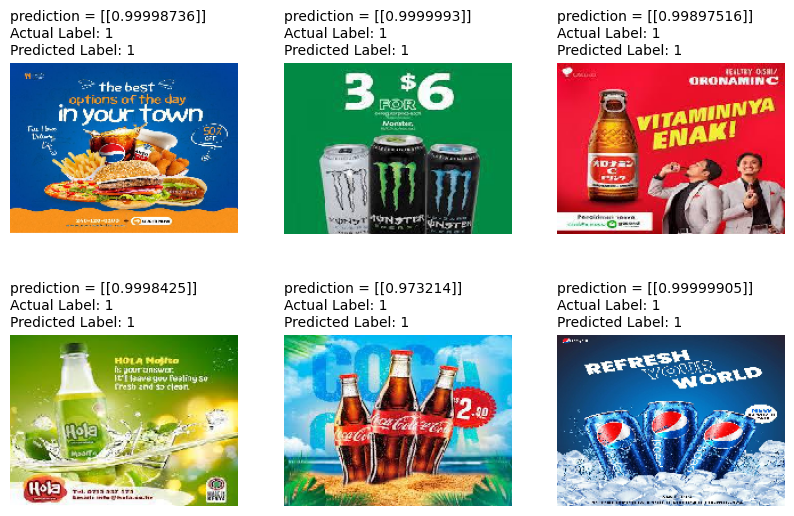

1/1 [==============================] - 0s 21ms/step
predictions =  [[0.02098239]]
Actual Label: 0
Predicted Label:  0
1/1 [==============================] - 0s 31ms/step
predictions =  [[3.289993e-07]]
Actual Label: 0
Predicted Label:  0
1/1 [==============================] - 0s 26ms/step
predictions =  [[0.00064613]]
Actual Label: 0
Predicted Label:  0
1/1 [==============================] - 0s 20ms/step
predictions =  [[0.00109276]]
Actual Label: 0
Predicted Label:  0
1/1 [==============================] - 0s 23ms/step
predictions =  [[6.85427e-05]]
Actual Label: 0
Predicted Label:  0
1/1 [==============================] - 0s 22ms/step
predictions =  [[0.00625363]]
Actual Label: 0
Predicted Label:  0


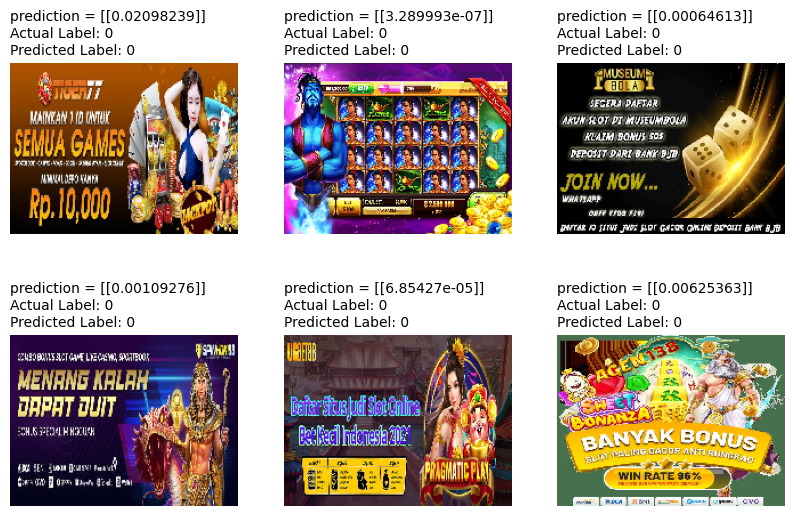

In [ ]:

for i in range(2):
  plt.figure(figsize=(10, 10))
  x_batch, y_batch = next(test_generator)
  for i in range (0,6):
      plt.subplot(3, 3, i + 1)
      image = x_batch[i]
      # Reshape the image to match the input shape expected by the model
      img = np.expand_dims(image, axis=0)

      # Make predictions
      predictions = loaded_model.predict(img)
      print("predictions = ", predictions)
      # Get the predicted class
      if(predictions[0] > 0.95):
        temp_predict = 1
      else:
        temp_predict = 0
      predicted_class = np.argmax(predictions[0])

      # Print the true label, predicted label, and display the image
      print(f"Actual Label: {int(y_batch[i])}")
      print("Predicted Label: ", temp_predict)
      plt.imshow(x_batch[i])
      plt.axis("off")
      plt.text(0, 1.25, f"prediction = {predictions}", transform=plt.gca().transAxes)
      plt.text(0, 1.15, f"Actual Label: {int(y_batch[i])}", transform=plt.gca().transAxes)
      plt.text(0, 1.05, f"Predicted Label: {temp_predict}", transform=plt.gca().transAxes)
  plt.show()

## Testing model melalui upload file

Saving 1.jpeg to 1 (1).jpeg
1/1 [==============================] - 0s 129ms/step
[[0.9525523]]
Predicted Label:  1


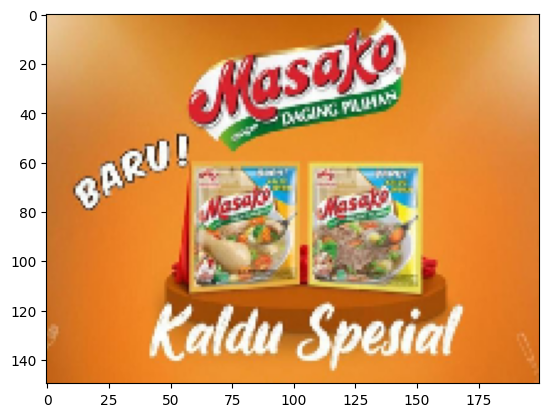

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

    # Predicting images
    path = fn
    img = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    imgplot = plt.imshow(img)

    # Preprocess the image for model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    # Make predictions
    predictions = loaded_model.predict(x)

    print(predictions)
    if(predictions[0] > 0.95):
        temp_predict = 1
    else:
        temp_predict = 0
    print("Predicted Label: ", temp_predict)